# Przetwarzanie szeregów czasowych w języku Python
Paweł Węgrzyniak <br>
2021-2022 <br>
Hurtownie danych i analiza danych (SP-198) 

### Cel projektu
Celem projektu jest utworzenie modelu prognozującego łączne tygodniowe zużycie energii cieplnej służącej ogrzewaniu mieszkań. 

>Model zostanie utworzony na podstawie danych pochodzących z odczytów 111 liczników energii cieplnej, przy czym część liczników jest powiązana z odczytami dotyczącymi zużyciu energii wykorzystanej do ogrzewania mieszkań, podczas gdy pozostała część liczników obejmuje dane o zużyciu energii wykorzystanej do ogrzewania wody.
Dane zostały zebrane na podstawie cogodzinych odczytów wykonanych w okresie od 01.09.2015 do 28.02.2019. Dane zostały pobrane ze strony http://www.cs.put.poznan.pl/rwrembel/energy-cons-data.html. Zbiór danych składa się ze 111 plików csv z odczytami z poszczególnych urządzeń oraz pliku csv zawierającego mapowanie poszczególnych urządzeń i typu licznika (odczyty energii do ogrzewania mieszkań lub wody). 

Pliki z odczytami z liczników zawierają następujące informacje:
- deviceID
- measurementID
- date and time (min|max date and time: 2015-09-01 00:00:00 | 2019-02-28 23:00:00)
- energy consumed [kWh]
- outside temperature [Celcius]
- wind velocity [m/s]
- outside air humidity [%]
- cloudiness [octan]
- day length [hours]
- day type {1: Mon, Tue, Wed, Thu; 2: Fri; 3: Sat; 4: Sun, holiday}
- season {1: spring (Mar,Arp,May); 2: summer (Jun,Jul,Aug); 3: autumn (Sep,Oct,Nov); 4: winter (Dec,Jan,Feb)} 

### Analiza wymagań
Utworzenie modelu prognozującego zużycie energii wymaga wykonania następujących kroków:
1. Wstępne przetwarzanie oraz czyszczenie danych
2. Przygotowanie modelu ARiMA
3. Ocena utworzonego modelu
4. Wizualizacja danych (na każdym etapie)

### Koncepcja rozwiązania z architekturą
Model zostanie utworzony w notatniku Jupyter z wykorzystaniem języka Python. W projekcie zostaną wykorzystane następujące biblioteki:
- Pandas - przetwarzanie danych z użyciem data frame 
- Matplotlib - wizualizacja danych
- Pmdarima - utworzenie modelu ARiMA
- statsmodels - dekompozycja danych

Kroki wymagane do utworzenia modelu:
1. Import bibliotek
2. Wczytanie danych (odczyty liczników energii oraz typy urządzeń)
3. Wstępne przetwarzanie oraz czyszczenie danych
	- Usunięcie pustych wierszy
	- Sformatowanie daty
	- Przypisanie typu licznika (licznik energii wykorzystanej do ogrzewania mieszkań CO, lub licznik energii wykorzystanej do ogrzewania wody CW)
	- Usunięcie zbędnych danych (Pozostawienie jedynie danych dotyczących zużycia energii wykorzystanej do ogrzewania mieszkań, usunięcie zbędnych kolumn)
	- Uzupełnienie brakujących danych na podstawie średnich wartości
	- Zagregowanie danych (zsumowanie danych dla kolejnych tygodni)
4. Przygotowanie modelu ARiMA
	- Ustalenie sezonowości
	- Określenie niektórych parametrów (sezonowość, stacjonarność, stopień różnicowania (differencing term))
	- Podział danych na dane treningowe oraz dane testowe (70% danych treningowych oraz 30% danych testowych
	- Utworzenie modelu z wykorzystaniem pmdarima - auto_arima
5. Ocena jakości modelu
	- Utworzenie predykcji na podstawie utworzonego modelu 
	- Wizualizacja predykcji
	- Obliczenie błędu

## Szczegóły implementacyjne


#### Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

#### Wczytanie danych
- Wczytanie danych ze wszystkich plików z odczytami do jednego data frame [raw_measurements].
- Wczytanie pliku z informacją o typie liczników.

In [2]:
# Wczytaj dane ze wszystkich plików z odczytami
path = r'raw_data_measurements'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, sep=';',decimal=",",
                      names=["DeviceID", "MeasurementID", "date_time", "energy_consumed","temperature", "wind_velocity", "air_humidity", "cloudiness", "day_length", "day_type", "season"])
    li.append(df)

raw_measurements = pd.concat(li, axis=0, ignore_index=True)
raw_measurements

,DeviceID,MeasurementID,date_time,energy_consumed,temperature,wind_velocity,air_humidity,cloudiness,day_length,day_type,season
0,5004,1.0,2015.09.01 00:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0
1,5004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5004,2.0,2015.09.01 01:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0
3,5004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5004,3.0,2015.09.01 02:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
6129495,5122,30646.0,2019.02.28 21:00:00,16.872,2.764,0.0,0.0,0.0,10.683,1.0,4.0
6129496,5122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6129497,5122,30647.0,2019.02.28 22:00:00,16.594,1.958,0.0,0.0,0.0,10.683,1.0,4.0
6129498,5122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Wczytaj dane o typach liczników
device_types = pd.read_csv('raw_data_device_types/device-types.csv')

# Wyodrębnij typ licznika z kolumny [DeviceCode]
device_types['device_type'] = device_types['DeviceCode'].str[-2:]
device_types = device_types.drop(['DeviceCode'], axis=1)
device_types

,DeviceID,device_type
0,5001,CO
1,5002,CO
2,5003,CO
3,5004,CO
4,5005,CW
...,...,...
143,5144,CO
144,5145,CO
145,5146,CO
146,5147,CO


### Wstępne przetwarzanie oraz czyszczenie danych

#### Wstępne przygotowanie danych
- Wczytane dane zawierają puste wiersze które muszą zostać usunięte.
- Data w kolumnie [date_time] nie została wczytana jako typ daty, co wymaga dodatkowego sformatowania kolumny.
- Pliki z odczytami nie pozwalają na identyfikację typu licznika, dla którego dokonano odczytu, z tego powodu konieczne jest dodanie kolumny z danymi z dodatkowego pliku csv zawierającego mapowanie typu licznika do nazwy urządzenia.

In [4]:
# Usunięcie pustych wierszy
df = raw_measurements.dropna(subset = ['MeasurementID']).reset_index(drop=True)

# Sformatowanie daty
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y.%m.%d %H:%M:%S')

# Przypisanie typu licznika
df = df.merge(device_types, how='left', on='DeviceID')

# Podgląd danych
df

,DeviceID,MeasurementID,date_time,energy_consumed,temperature,wind_velocity,air_humidity,cloudiness,day_length,day_type,season,device_type
0,5004,1.0,2015-09-01 00:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0,CO
1,5004,2.0,2015-09-01 01:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0,CO
2,5004,3.0,2015-09-01 02:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0,CO
3,5004,4.0,2015-09-01 03:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0,CO
4,5004,5.0,2015-09-01 04:00:00,0.000,0.000,0.0,0.0,0.0,13.750,1.0,3.0,CO
...,...,...,...,...,...,...,...,...,...,...,...,...
3064795,5122,30644.0,2019-02-28 19:00:00,16.955,3.517,0.0,0.0,0.0,10.683,1.0,4.0,CO
3064796,5122,30645.0,2019-02-28 20:00:00,16.946,3.268,0.0,0.0,0.0,10.683,1.0,4.0,CO
3064797,5122,30646.0,2019-02-28 21:00:00,16.872,2.764,0.0,0.0,0.0,10.683,1.0,4.0,CO
3064798,5122,30647.0,2019-02-28 22:00:00,16.594,1.958,0.0,0.0,0.0,10.683,1.0,4.0,CO


#### Usunięcie zbędnych danych
- Model zostanie utworzony na podstawie odczytów liczników energii wykorzystywanej do ogrzewania domów (CO). Z tego powodu zostanie utworzony nowy data frame zawierający tylko odczyty CO.
- W modelu Arima może zostać wykorzystana tylko jedna seria danych (w tym przypadku odczyty energii CO). Pozostałe kolumny zostaną usunięte.

In [5]:
# Utwórz data frame zawierający jedynie odczyty 
co_data = df[df['device_type'] == 'CO'].reset_index(drop=True)

# Pozostaw jedynie kolumny z datą i wartością zużytej energii.
co_data = co_data[['date_time', 'energy_consumed']]
co_data

,date_time,energy_consumed
0,2015-09-01 00:00:00,0.000
1,2015-09-01 01:00:00,0.000
2,2015-09-01 02:00:00,0.000
3,2015-09-01 03:00:00,0.000
4,2015-09-01 04:00:00,0.000
...,...,...
2237299,2019-02-28 19:00:00,16.955
2237300,2019-02-28 20:00:00,16.946
2237301,2019-02-28 21:00:00,16.872
2237302,2019-02-28 22:00:00,16.594


<function matplotlib.pyplot.show(close=None, block=None)>

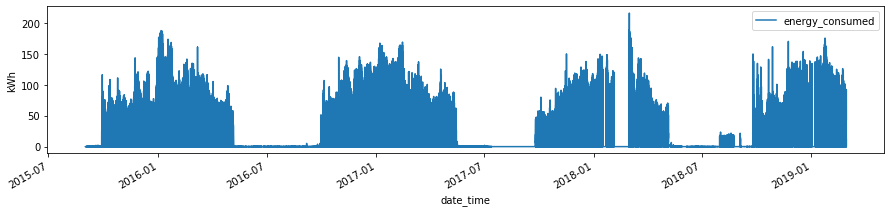

In [6]:
co_data.plot(x="date_time", y=["energy_consumed"], ylabel='kWh', figsize=(15, 3))
plt.show

W roku 2018 możemy zaobserwować znaczne braki w danych, które występują w środku sezonu grzewczego. Konieczne jest oszacowanie ilości zużytej energii w tym okresie.

### Uzupełnienie brakujących danych z roku 2018 na podstawie średnich wartości z pozostałych okresów
- W podglądzie przygotowanych danych w poprzenim punkcie możemy zauważyć okresy z brakującymi danymi w środku okresu zimowego. Jest to za długi okres, aby założyć że odczyty są poprawne, a brak zużycia energii w tym okresie wynika z faktycznie korzystnych warunków. Odniesieniem mogą być odczyty w Roztoczańskim Parku Narodowym które wskazują że średnia temperatura w lutym 2018 wyniosła -3,6°C (https://dobrapogoda24.pl/artykul/pogoda-klimat-rzeszow-rok-2018).
- Brakujące dane zostaną oszacowane na podstawie średnich wartości zaobserwowanych w analogicznych okresach w innych latach. 

In [7]:
# Wyodrębnij wartości z lutego w innych latach
co_for_replacement = co_data[['date_time', 'energy_consumed']][(co_data['date_time'].dt.year != 2018)
                                                    & (co_data['date_time'].dt.day != 29)] #dzień przestępny z innych lat

# Zagreguj jako rok 2018
co_for_replacement['date_time'] = co_for_replacement['date_time'].apply(lambda dt: dt.replace(year=2018))
co_for_replacement = co_for_replacement.groupby('date_time', as_index=False).agg(energy_consumed=('energy_consumed', 'mean'))
co_for_replacement

,date_time,energy_consumed
0,2018-01-01 00:00:00,37.423731
1,2018-01-01 01:00:00,36.166918
2,2018-01-01 02:00:00,35.143726
3,2018-01-01 03:00:00,34.983178
4,2018-01-01 04:00:00,34.278201
...,...,...
8491,2018-12-31 19:00:00,38.638904
8492,2018-12-31 20:00:00,37.739288
8493,2018-12-31 21:00:00,37.264571
8494,2018-12-31 22:00:00,37.611251


In [8]:
# Dodaj kolumnę z oszacowanymi danymi do danych CO
co_data_adj = co_data.copy()
co_data_adj = co_data_adj.merge(co_for_replacement[['date_time', 'energy_consumed']],on='date_time',how="left")

# Zastąp brakujące dane oszacowanymi wartościami
co_data_adj['energy_consumed_x'] = np.where((co_data_adj['energy_consumed_x'] == 0) & (co_data_adj['energy_consumed_y'].notnull()), co_data_adj['energy_consumed_y'], co_data_adj['energy_consumed_x'])
co_data_adj.drop(["energy_consumed_y"], inplace=True, axis=1)
co_data_adj.rename(columns={'energy_consumed_x':'energy_consumed'},inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

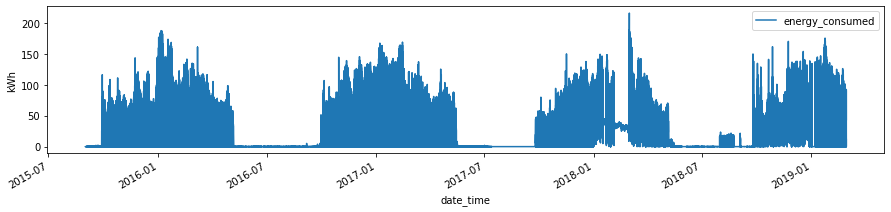

In [9]:
# Zwizualizuj dane po uzupełnieniu brakująch wartości
co_data_adj.plot(x="date_time", y=["energy_consumed"], ylabel='kWh', figsize=(15, 3))
plt.show

Na powyższym wykresie widzimy że brakujące dane z roku 2018 zostały zastąpione średnimi wartościami z pozostałych lat.

#### Zagregowanie danych
Dane będą analizowane w ujęciu tygodniowym, także konieczne jest ich zagregowanie.

<function matplotlib.pyplot.show(close=None, block=None)>

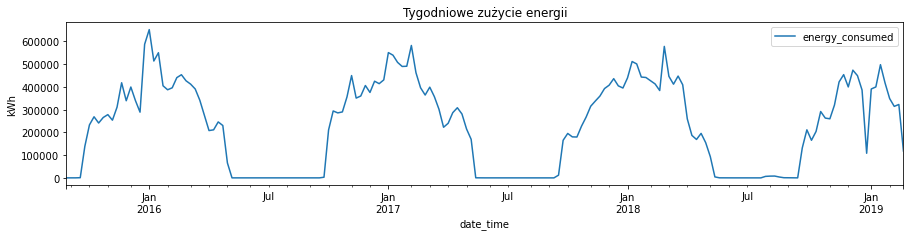

In [10]:
# Use [resample] to aggregate data weekly.
# https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4

# Zagreguj dla dnia rozpoczęcia tygodnia (poniedziałek)
co_weekly = co_data_adj[['date_time', 'energy_consumed']]
co_weekly['date_time'] = co_weekly['date_time'] - pd.to_timedelta(7, unit='d')
co_weekly = co_weekly.resample('W-Mon', on='date_time').sum().reset_index()

# Zwizualizuj zagregowane dane
co_weekly.plot(x="date_time", y=["energy_consumed"], title='Tygodniowe zużycie energii', ylabel='kWh' , figsize=(15, 3))
plt.show

#

#### Dodatkowe wizualizacje danych
Dodatkowe wizualizacje pozwalające lepiej zrozumieć dane.
- Rozkład danych (decomposition).
- Średnia ruchoma, ruchome odchylenie standardowe, test Dickeya-Fullera.
- Autokorelacja.

##### Rozkład danych (decomposition)
Wyodrębnienie trendu, sezonowości i pozostałych danych.

C:\Users\User\AppData\Local\Temp/ipykernel_12576/1515936289.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(co_weekly.energy_consumed, freq=52)


<Figure size 432x288 with 0 Axes>

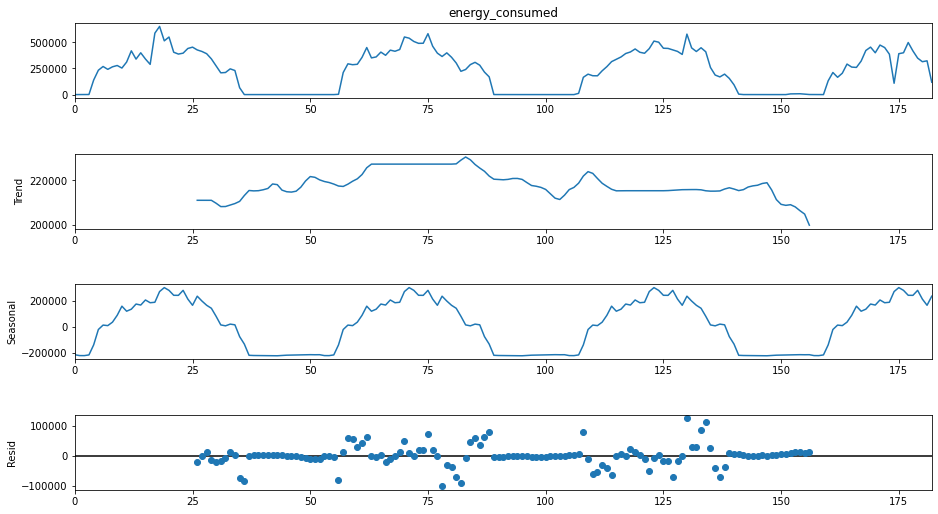

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(co_weekly.energy_consumed, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

# Jak odnieść się do poszczególnych elementów rozkładu?
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

##### Test Dickeya-Fullera
Test pozwalający ocenić czy dane są stacjonarne

In [12]:
# Utwórz funkcję pozwalającą przeprowadzić test Dickeya-Fullera

# For testing stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
                
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std() # pd.rolling_std(timeseries, window=364)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

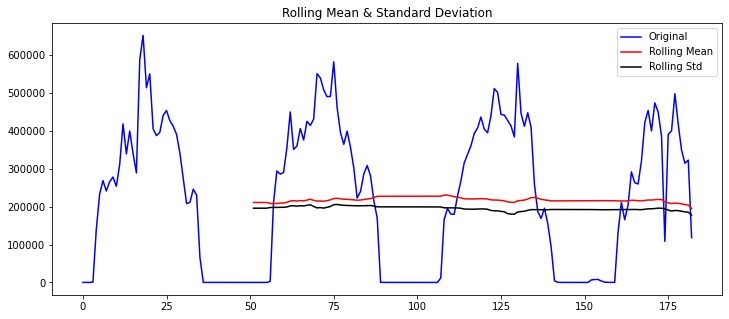

Results of Dickey-Fuller Test:
Test Statistic                  -5.154430
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    169.000000
Critical Value (1%)             -3.469648
Critical Value (5%)             -2.878799
Critical Value (10%)            -2.575971
dtype: float64


In [13]:
# Wykonaj test
test_stationarity(co_weekly['energy_consumed'])

Według powyższego testu dane zużycia energii są stacojnarne (test statistic jest mniejsze niż critical value)

##### Autokorelacja
Wykresy autokorelacji pozwalają ustalić niektóre parametry modelu ARiMA oraz konieczność różnicowania danych (differencing).

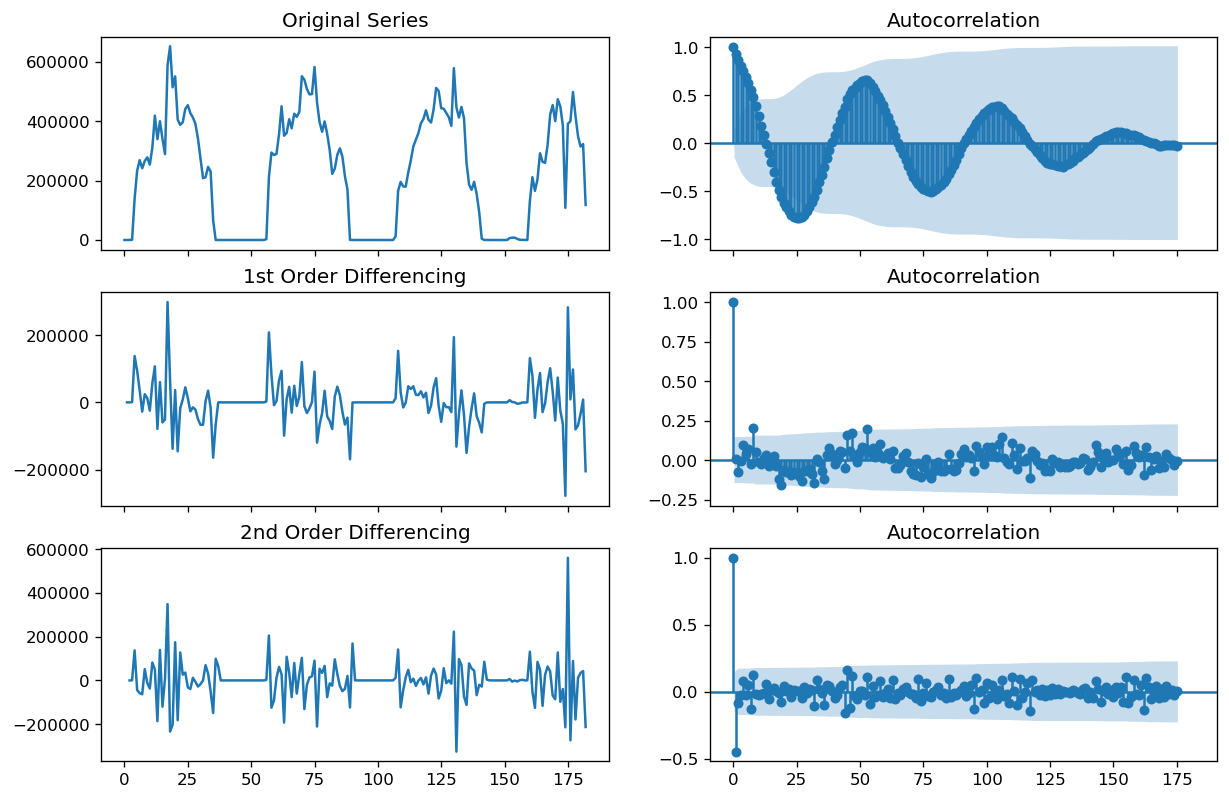

In [14]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(co_weekly['energy_consumed']); axes[0, 0].set_title('Original Series')
plot_acf(co_weekly['energy_consumed'], lags=175, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(co_weekly['energy_consumed'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(co_weekly['energy_consumed'].diff().dropna(), lags=175, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(co_weekly['energy_consumed'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(co_weekly['energy_consumed'].diff().diff().dropna(), lags=175, ax=axes[2, 1])

plt.show()


## Seasonal ARIMA

<function matplotlib.pyplot.show(close=None, block=None)>

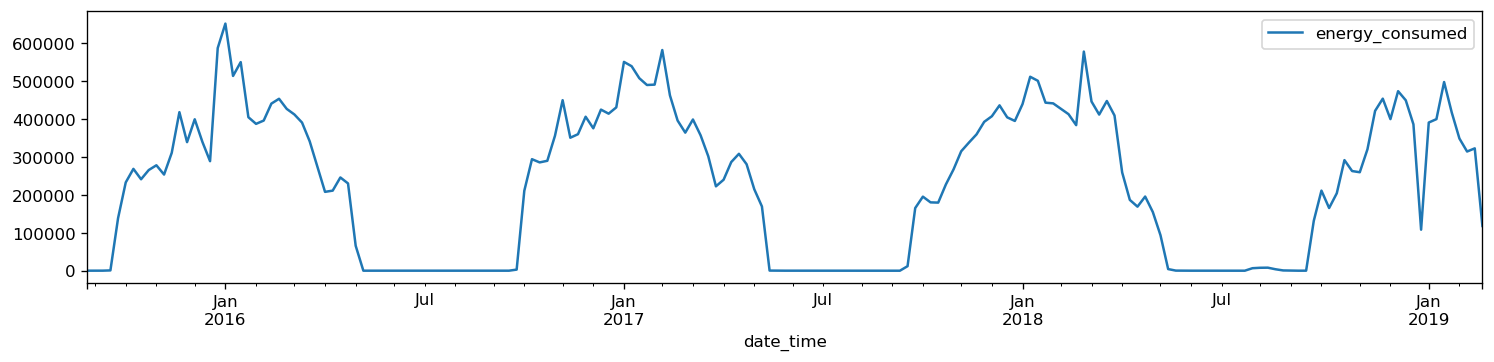

In [15]:
df = co_weekly.copy()
df.plot(x="date_time", y=["energy_consumed"], figsize=(15, 3))
plt.show

#### Podział danych na dane treningowe oraz dane testowe
70% danych zostanie przypisana jako dane treningowe, pozostała część zostanie użyta do oceny utworzonego modelu.

<function matplotlib.pyplot.show(close=None, block=None)>

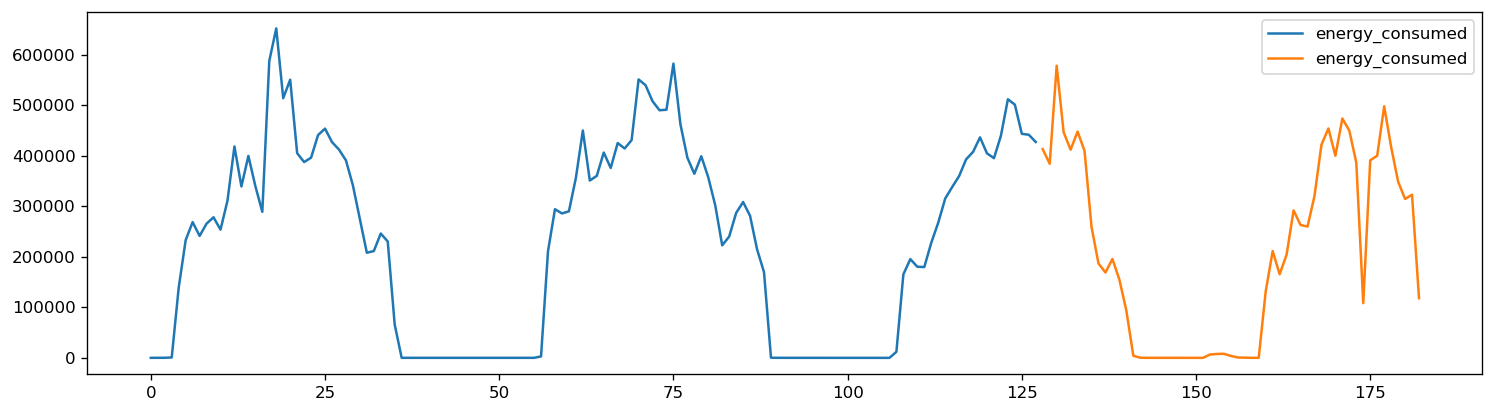

In [16]:
train = df[:int(0.7*(len(df)))]
valid = df[int(0.7*(len(df))):]
train['energy_consumed'].plot(figsize=(15, 4))
valid['energy_consumed'].plot(figsize=(15, 4))
plt.legend(loc = 'upper right')
plt.show

In [17]:
from pmdarima.arima.stationarity import ADFTest
adf_test = ADFTest(alpha=0.05)
# adf_test.is_stationary(train['energy_consumed'])
print(adf_test.should_diff(df['energy_consumed'])) #should_diff replaces deprecated is_stationary.


(0.30079464879299694, True)


#### Ustalenie stopnia różnicowania (differencing term)
Model ARiMA wymaga aby dane były stacjonarne. Wykonamy testy pozwalające zweryfikować czy dane powinny zostatać zróżnicowane (parametr [d]).
Jako że analizujemy dane z wyraźną sezonowością musimy ustalić differencing term również dla sezonowej części modelu [D].
Wykonamy test KPSS (Kwiatkowski–Phillips–Schmidt–Shin), aby ustalić [d] oraz test OCSB w celu ustalenia [D].

In [18]:
# check what [d] (differencing term) should we use - test kpss
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html#pmdarima.arima.ndiffs 
from pmdarima.arima import ndiffs
ndiffs(train['energy_consumed'], alpha=0.05, test='kpss', max_d=5)

0

In [19]:
# check what [D] (seasonal differencing term) should we use
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html#pmdarima.arima.nsdiffs
from pmdarima.arima import nsdiffs
nsdiffs(train['energy_consumed'], 52, test='ocsb', max_D=5)

0

Oba testy wskazują że dane nie wymagają różnicowania. Korzystając z tych informacji zostanie stworzony pierwszy model z użyciem biblioteki pmdarima i funkcji auto_arima, która pozwala na automatyczne wyszukanie odpowiednich parametrów modelu.

In [20]:
# d i D ustawione zgodnie z wynikami wyżej
from pmdarima.arima import auto_arima
arima_model = auto_arima(train['energy_consumed'], method='nm', maxiter=30, 
                        start_p=1, start_q=1, max_p=4, max_q=4, 
                        start_P=0, start_Q=0, max_P=4, max_Q=4, m=52, 
                        seasonal=True, trace=True, d=0, D=0, error_action='warn', 
                        suppress_warnings=True, stepwise=True, random_state=20)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=3185.400, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3482.280, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3195.217, Time=1.44 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3349.859, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3595.819, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=3222.825, Time=1.38 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=3187.446, Time=1.34 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=3189.463, Time=1.34 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=3345.591, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3187.475, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=3183.456, Time=0.11 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3207.026, Time=1.43 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=3185.451, Time=1.11 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=3187.476, Time=1.25 sec
 ARIMA(2,0,0)(0,0,0

In [21]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  128
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1586.728
Date:                Sun, 05 Jun 2022   AIC                           3183.456
Time:                        19:06:05   BIC                           3197.716
Sample:                             0   HQIC                          3189.250
                                - 128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     1.8e+04   1.53e+04      1.173      0.241   -1.21e+04    4.81e+04
ar.L1          0.3932      0.196      2.003      0.045       0.008       0.778
ar.L2          0.5135      0.195      2.640      0.008       0.132       0.895
ma.L1          0.7677      0.130      5.916      0.000       0.513       1.022
sigma2      3.314e+09      0.407   8.15e+09      0.000    3.31e+09    3.31e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               147.84
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.48e+24. Standard errors may be unstable.
"""

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods=55),index=valid.index)
prediction.columns = ['prediction']
# prediction

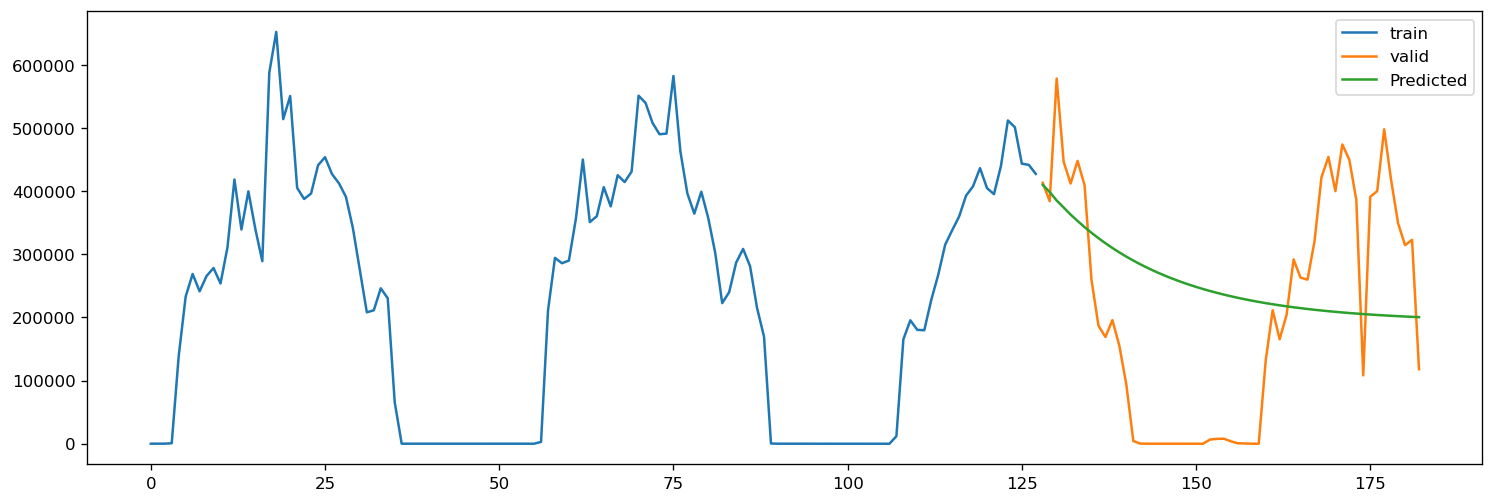

In [23]:
plt.figure(figsize=(15,5))
plt.plot(train['energy_consumed'], label='train')
plt.plot(valid['energy_consumed'], label='valid')
plt.plot(prediction, label="Predicted")
plt.legend(loc = 'upper right')
plt.show()

Prognoza bardzo słabo opisuje dane. Utworzymy jeszcze jeden model korzystając z domyślnej metody - LBFGS zamiast NM.

In [24]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(train['energy_consumed'], maxiter=50, 
                        start_p=0, start_q=0, max_p=8, max_q=8, 
                        start_P=0, start_Q=0, max_P=8, max_Q=8, m=52, 
                        seasonal=True, trace=True, d=0, D=0, error_action='warn', 
                        suppress_warnings=True, stepwise=True, random_state=20)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3482.280, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3184.945, Time=1.49 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3390.552, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3595.819, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3187.786, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=3186.428, Time=8.53 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=3186.945, Time=2.09 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=3185.399, Time=1.15 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=3187.800, Time=13.42 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=3468.506, Time=3.27 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=3185.969, Time=2.33 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=3185.223, Time=2.43 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=3393.341, Time=1.35 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3183.088, Time=2.66 sec
 ARIMA(2,0,1)(0,0,

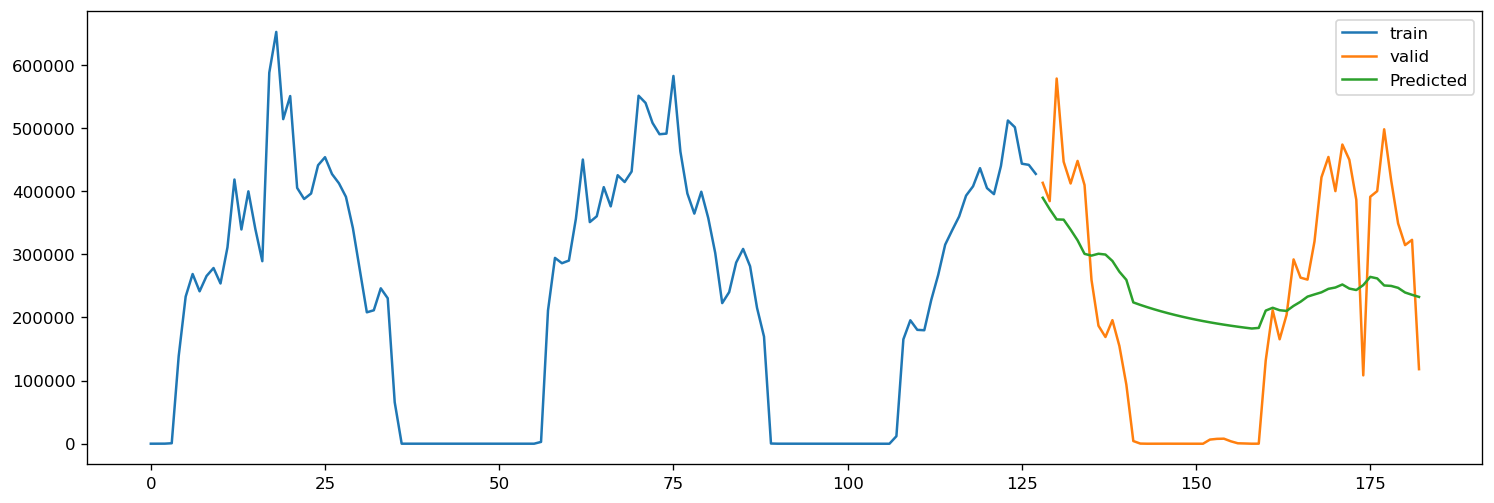

In [25]:
prediction = pd.DataFrame(arima_model.predict(n_periods=55),index=valid.index)
prediction.columns = ['prediction']
plt.figure(figsize=(15,5))
plt.plot(train['energy_consumed'], label='train')
plt.plot(valid['energy_consumed'], label='valid')
plt.plot(prediction, label="Predicted")
plt.legend(loc = 'upper right')
plt.show()

Prognoza lepiej opisuje dane jednak wciąż jest bardzo niedokładna. Wykonamy dodatkowe testy na stacjonarność, aby upewnić się że używamy odpowiednich parametrów [d] oraz [D].

In [26]:
# check what [d] (differencing term) should we use - test kpss
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html#pmdarima.arima.ndiffs 
from pmdarima.arima import ndiffs
ndiffs(train['energy_consumed'], alpha=0.05, test='adf', max_d=5)

1

In [27]:
# check what [D] (seasonal differencing term) should we use
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html#pmdarima.arima.nsdiffs
from pmdarima.arima import nsdiffs
nsdiffs(train['energy_consumed'], 52, test='ch', max_D=5)

1

Wykonane powyżej testy wskazują że powinniśmy użyć  parametrów [d] oraz [D] o wartości 1.

In [28]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(train['energy_consumed'], maxiter=100,
                        start_p=0, start_q=0, max_p=4, max_q=4, 
                        start_P=0, start_Q=0, max_P=4, max_Q=4, m=52, 
                        seasonal=True, trace=True, d=1, D=1, error_action='warn', 
                        suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1915.941, Time=1.88 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1878.236, Time=2.88 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1874.878, Time=3.41 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1894.160, Time=0.72 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1875.651, Time=6.49 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1875.336, Time=10.81 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1876.817, Time=3.02 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=1877.316, Time=20.68 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=35.34 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1874.668, Time=6.58 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=1887.947, Time=1.21 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=1875.901, Time=8.85 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=1875.678, Time=20.12 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1876.514, Time=6.39 sec
 ARIMA(1,1,1)(1,1,2)

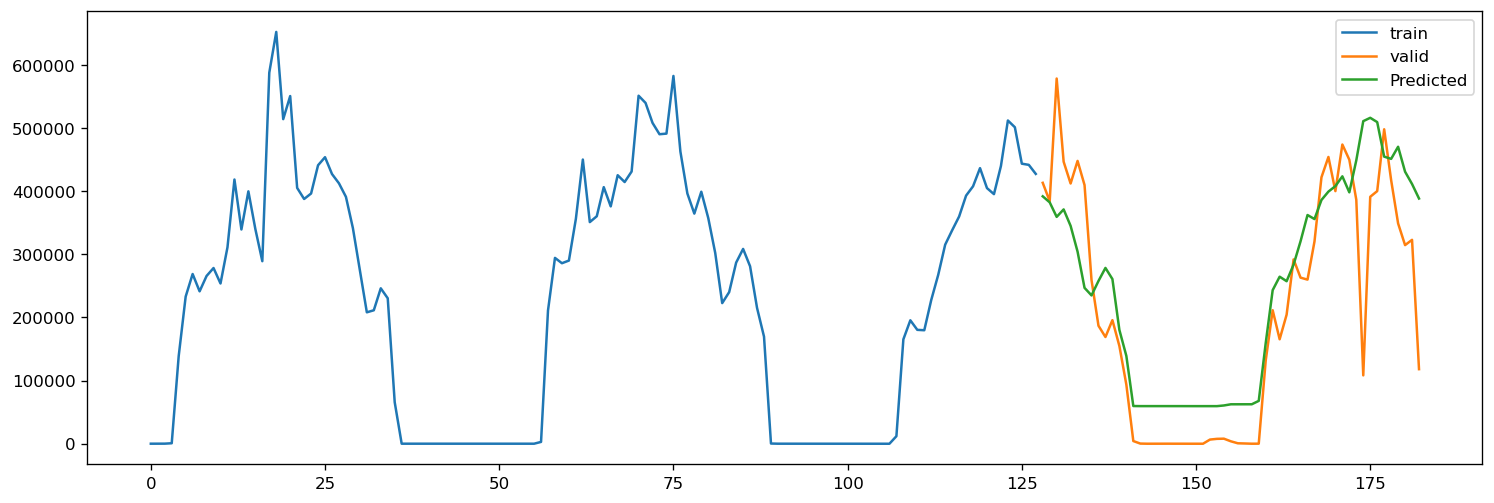

In [29]:
prediction = pd.DataFrame(arima_model.predict(n_periods=55),index=valid.index)
prediction.columns = ['prediction']
plt.figure(figsize=(15,5))
plt.plot(train['energy_consumed'], label='train')
plt.plot(valid['energy_consumed'], label='valid')
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper right')
plt.show()

#### Ocena jakości modelu

W celu oceny jakości utworzonego modelu przeanalizujemy wykres przedstawiający dane rzeczywiste oraz dane prognozowane. Zostanie również obliczonych kilka rodzajów błędów:
- MSE (mean squared error).
    - MSE pozwala w jednakowy sposób traktować zarówno negatywne jak i pozytywne wartości. 
    - W przypadku MSE błędy o większych bezwględnych wartościach mają większy wpływ na ocenę.
- RMSE (root-mean-square error).
    - Jest to pierwiastek kwadratowy z MSE - umożliwia przeskalowanie błędu do zakresu oryginalnych wartości. 
- MAE (mean absolute error).
    - Przy wyliczaniu błędu MAE każdy błąd ma proporcjonalny wpływ na wynik, w przeciwieństwie do wspomnianego wyżej błędu MSE, w którym większe błędy mają większy wpływ.
- MAPE (mean absolute percentage error).
    - Daje wyobrażenie o wielkości błędów w porównaniu z rzeczywistymi wartościami.

##### Analiza wykresu

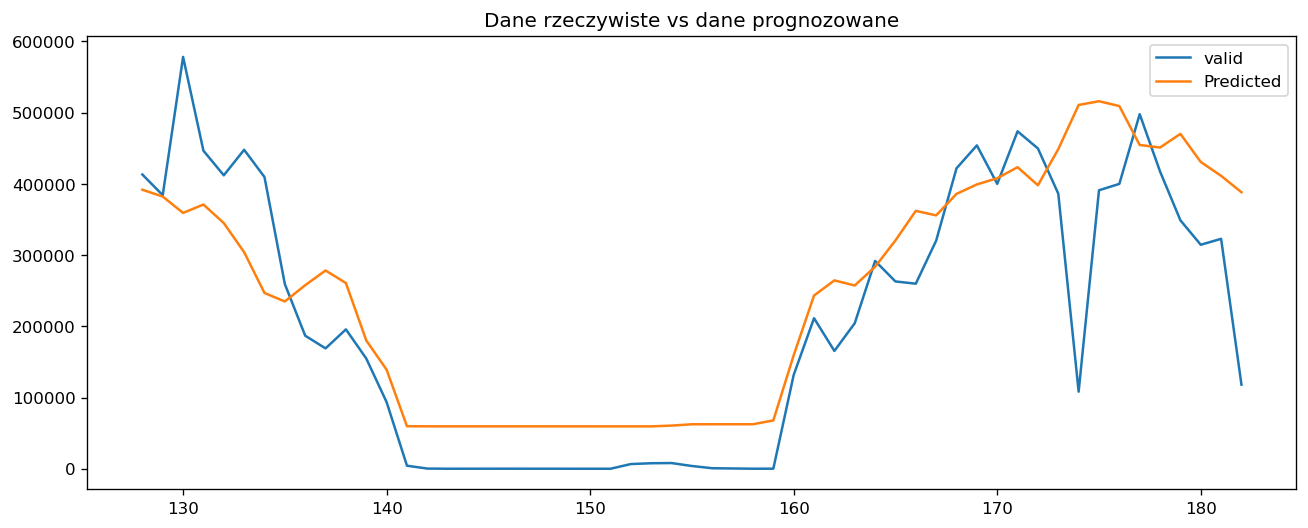

In [30]:
# Utwórz wykres przedstawiający dane rzeczywiste oraz dane prognozowane.

plt.figure(figsize=(13,5))
plt.plot(valid['energy_consumed'], label='valid')
plt.plot(prediction, label="Predicted")
plt.legend(loc = 'upper right')
plt.title(label = 'Dane rzeczywiste vs dane prognozowane')
plt.show()

Na podstawie powyższego wykresu możemy stwierdzić że prognoza całkiem poprawnie opisuje dane rzeczywiste. Wyjątkiem jest jednak okres pomiędzy indeksami 140 i 160 dla którego rzeczywiste wartości były zbliżone do zera, podczas gdy model przewidział wartości w okolicach 60000 kWh. Drugą znaczną różnicę możemy zaobserwować przy gwałtownym spadku w danych rzeczywistych pomiędzy indeksami 170 i 180. W tym przypadku jednak najprawdopodobniej wynika on z brakujacych danych rzeczywistych w tym okresie.

##### Obliczenie błędów

In [31]:
# Krótkie podsumowanie danych prognozowanych oraz rzeczywistych
evaluation = prediction
evaluation = evaluation.assign(original = valid['energy_consumed'], 
                                errors = prediction['prediction'] - valid['energy_consumed'])
evaluation.describe()

,prediction,original,errors
count,55.000000,55.000000,55.000000
mean,250135.324367,209761.512955,40373.811412
std,160216.433231,184297.298070,91462.963301
min,59538.624670,20.116527,-219071.529428
25%,61536.793095,2288.359892,2998.402304
50%,260777.155938,195733.664644,58614.319101
75%,390065.595267,395551.263000,62476.750568
max,516127.494465,578322.546016,402563.662872


In [32]:
errors = prediction['prediction'] - valid['energy_consumed']

# mean squared error
mse = np.square(errors).mean()
print('mse: ' + str(mse))

# root-mean-square error
rmse = np.sqrt(mse)
print('rmse: ' + str(rmse))

# mean absolute error
mae = np.abs(errors).mean()
print('mae: ' + str(mae))

# mean absolute percentage error
mape = np.abs(errors / valid['energy_consumed']).mean()
print('mape: ' + str(mape))

mse: 9843418782.714655
rmse: 99214.00497265825
mae: 75289.47561967603
mape: 282.7551388911889


Obliczone błędy wskazują na wysoką niedokładność prognozy, co najprawdopodobniej wynika z różnic zaobserwowanych na poprzednim wykresie. Wagę błędu najlepiej obrazuje błąd MAPE (mean absolute percentage error), który wskazuje że średnio błąd wynosi ~282% wartości rzeczywistej.